last version with right number of exposure for the whole LSST survey (https://arxiv.org/pdf/0805.2366.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sys
import os
import logging
import galsim
import cmath as cm
import math
import random
import scipy
from importlib import reload
from scipy.stats import norm
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
from multiprocess import *
import pandas as pd
import seaborn as sns

import pathlib
from pathlib import Path


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import plot, utils


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
%run -i ../../scripts/Images_generation/images_generator.py
%run -i ../../scripts/Images_generation/cosmos_params.py

1


In [4]:
bands = [0,1,2,3,4,5,6,7,8,9]
pixel_scale_lsst = 0.2

# Test of recorded images

In [29]:
data_dir = '/sps/lsst/users/barcelin/data/isolated_galaxies/27.5/miscentered_0.1/training/'
root = 'galaxies_blended_20191024'

In [30]:
images = np.load(data_dir+'galaxies_isolated_20191024_0_images.npy', mmap_mode = 'c')

In [31]:
images.shape

(10000, 2, 10, 64, 64)

In [32]:
maxs = np.max(images[:,0,6], axis = (1,2))

In [33]:
maxs.shape

(10000,)

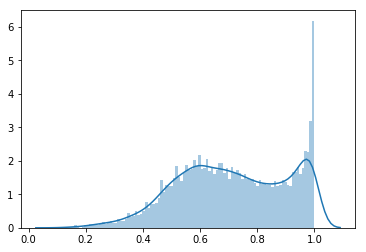

In [34]:
sns.distplot(maxs, bins = 100)

0.6057019094403011

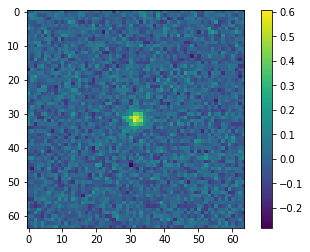

In [40]:
plt.imshow(images[100,1,6])
plt.colorbar()
np.max(images[100,1,6])

In [126]:
data_dir = '/sps/lsst/users/barcelin/data/blended_galaxies/27.5/miscentered_peak/test'
root = 'galaxies_blended_20191024'

In [127]:
test = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/27.5/miscentered_peak/test/galaxies_blended_20191024_0_images.npy', mmap_mode = 'c')

In [128]:
shifts = np.load('/sps/lsst/users/barcelin/data/blended_galaxies/27.5/miscentered_peak/test/galaxies_blended_20191024_0_shifts.npy')

In [129]:
dfs = []

dfs.append(pd.read_csv(os.path.join(data_dir, root+'_0_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [130]:
test.shape

(10000, 2, 10, 64, 64)

In [131]:
bands = [0,1,2,3,4,5,6,7,8,9]
pixel_scale_lsst = 0.2

In [132]:
input_noisy = test[:,1]
input_noiseless = test[:,0]

In [133]:
reload(utils)

<module 'tools_for_VAE.utils' from '../../scripts/tools_for_VAE/tools_for_VAE/utils.py'>

In [134]:
input_noisy = utils.norm(input_noisy, bands, data_dir, inplace = False)
input_noiseless = utils.norm(input_noiseless, bands, data_dir, inplace = False)

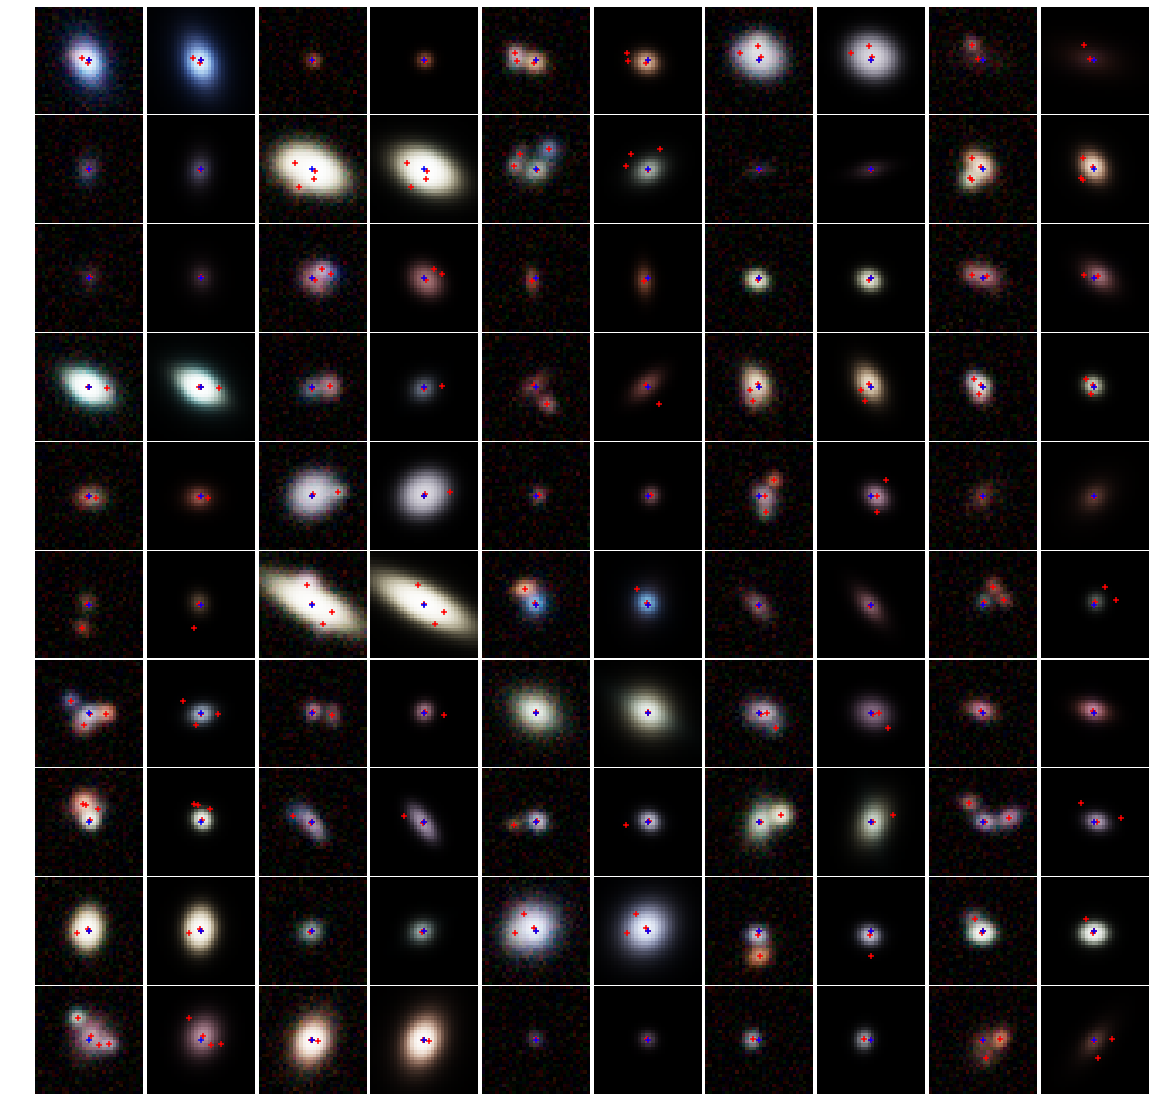

In [135]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,2):    
        plot.plot_rgb(input_noisy[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[indices[i+j*N_plot]], bands = [5,6,7],ax= axes[i,j+1], band_first= True,zoom = 2, shifts = shifts[indices[i+j*N_plot]]/pixel_scale_lsst)
        axes[i,j].axis('off')        
        axes[i,j+1].axis('off')

In [136]:
import astropy
import photutils

In [137]:
from photutils import find_peaks
from astropy.stats import sigma_clipped_stats

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

In [138]:
images = input_noiseless[:10000]

In [139]:
input_noisy = utils.denorm(input_noisy, bands,data_dir, inplace = False)

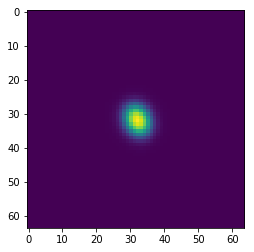

In [140]:
plt.imshow(images[41,6])

In [142]:
len(images)

10000

In [150]:
def peak_detection(denormed_img, band, shifts, img_size, npeaks, nb_blended_gal, training_or_test, dist_cut):
    gal = denormed_img
    df_temp = photutils.find_peaks(gal, threshold=5*np.sqrt(sky_level_pixel[band]), npeaks=npeaks, centroid_func=centroid_com)
    if df_temp is not None:
        df_temp['x_peak'] = (df_temp['x_centroid']-((img_size/2.)-0.5))*pixel_scale[band]
        df_temp['y_peak'] = (df_temp['y_centroid']-((img_size/2.)-0.5))*pixel_scale[band]
        df_temp.sort('peak_value', reverse=True)
        # Distances of true centers to brightest peak
        qq = [np.sqrt(float((shifts[j,0]-df_temp['x_peak'][0])**2+ (shifts[j,1]-df_temp['y_peak'][0])**2)) for j in range(nb_blended_gal)]
        idx_closest = np.argmin(qq)
        if nb_blended_gal>1:
            # Distance from peak galaxy to others
            qq_prime = [np.sqrt(float((shifts[idx_closest,0]-shifts[j,0])**2+ (shifts[idx_closest,1]-shifts[j,1])**2)) if j!=idx_closest else np.inf for j in range(nb_blended_gal)]
            idx_closest_to_peak_galaxy = np.argmin(qq_prime)
            if training_or_test != 'test':
                if not np.all(np.array(qq_prime) > dist_cut):
                    print('TRAINING CUT: closest is not central and others are too close')
                    return False
        else:
            idx_closest_to_peak_galaxy = np.nan
        return np.min(qq), idx_closest, idx_closest_to_peak_galaxy, df_temp[0]['x_centroid'], df_temp[0]['y_centroid'], df_temp[0]['x_peak'], df_temp[0]['y_peak'], len(df_temp)
    else:
        print('too bad')
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        #return False

In [151]:
band = 6
peak_detection_output = []

for i in range (len(input_noisy)):
    peak_detection_output.append(peak_detection(input_noisy[i,6],
                                   band, 
                                   shifts[i], 
                                   max_stamp_size, 
                                   4,
                                   df['nb_blended_gal'][i],
                                   'test', 
                                   dist_cut=0.65/2.))#/2.

too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad
too bad


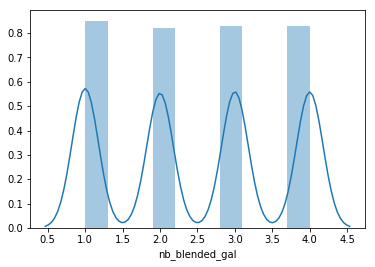

In [145]:
sns.distplot(df['nb_blended_gal'], bins = 10)

In [146]:
import scipy

In [149]:
np.array(peak_detection_output[0])

(8,)

In [155]:
df_peak = pd.DataFrame()

df_peak['min_dist'] = np.array(peak_detection_output)[:,0]
df_peak['idx_closest'] = np.array(peak_detection_output)[:,1]
df_peak['idx_closest_to_peak_galaxy'] = np.array(peak_detection_output)[:,2]
df_peak['x_centroid'] = np.array(peak_detection_output)[:,3]
df_peak['y_centroid'] = np.array(peak_detection_output)[:,4]
df_peak['x_peak'] = np.array(peak_detection_output)[:,5]
df_peak['y_peak'] = np.array(peak_detection_output)[:,6]
df_peak['nb'] = np.array(peak_detection_output)[:,7]

In [160]:
df_peak = df_peak.dropna()

In [161]:
df_peak['min_dist']

0       0.035382
1       0.101838
2       0.026296
5       0.116200
6       0.063589
7       0.039935
8       0.083979
10      0.038076
11      0.028690
12      0.056997
13      0.091954
14      0.101807
15      0.265432
18      0.036956
19      0.018334
20      0.143298
21      0.166903
22      0.136215
23      0.069249
25      0.052741
26      0.129275
27      0.089878
29      0.027605
30      0.075901
31      0.065601
32      0.172185
35      0.064995
37      0.054729
39      0.229031
40      0.046090
          ...   
9960    0.016621
9961    0.060907
9963    0.056756
9964    0.136353
9966    0.083186
9968    0.058921
9969    0.061648
9970    0.070466
9971    0.022963
9972    0.108926
9973    0.034154
9974    0.076279
9975    0.102109
9977    0.145973
9978    0.239152
9979    0.167531
9980    0.038632
9981    0.130128
9983    0.089117
9986    0.043617
9987    0.131286
9988    0.339965
9989    0.156895
9990    0.066623
9992    0.139195
9995    0.093022
9996    0.042378
9997    0.0636

In [167]:
# Old beta_prime parameters
beta_prime_parameters = (14.022429614276358, 6.922508843325913, -0.0247188726955977, 0.04994196562063914)

In [238]:
x = np.linspace(scipy.stats.betaprime.ppf(0.01,*beta_prime_parameters),
                scipy.stats.betaprime.ppf(0.99,*beta_prime_parameters), 100)

In [239]:
x

array([0.01140797, 0.0145101 , 0.01761222, 0.02071435, 0.02381647,
       0.0269186 , 0.03002072, 0.03312285, 0.03622497, 0.0393271 ,
       0.04242922, 0.04553135, 0.04863347, 0.0517356 , 0.05483772,
       0.05793985, 0.06104197, 0.0641441 , 0.06724622, 0.07034835,
       0.07345047, 0.0765526 , 0.07965472, 0.08275685, 0.08585897,
       0.0889611 , 0.09206322, 0.09516535, 0.09826747, 0.1013696 ,
       0.10447172, 0.10757385, 0.11067597, 0.1137781 , 0.11688022,
       0.11998235, 0.12308447, 0.1261866 , 0.12928872, 0.13239085,
       0.13549297, 0.1385951 , 0.14169722, 0.14479935, 0.14790147,
       0.1510036 , 0.15410572, 0.15720785, 0.16030998, 0.1634121 ,
       0.16651423, 0.16961635, 0.17271848, 0.1758206 , 0.17892273,
       0.18202485, 0.18512698, 0.1882291 , 0.19133123, 0.19443335,
       0.19753548, 0.2006376 , 0.20373973, 0.20684185, 0.20994398,
       0.2130461 , 0.21614823, 0.21925035, 0.22235248, 0.2254546 ,
       0.22855673, 0.23165885, 0.23476098, 0.2378631 , 0.24096

In [240]:
scipy.stats.betaprime.pdf(x,*beta_prime_parameters)

array([1.65548703, 2.30540015, 3.03462864, 3.81326949, 4.60988063,
       5.39463135, 6.14148329, 6.82942197, 7.44289661, 7.97167683,
       8.41033073, 8.75749635, 9.01507691, 9.18744964, 9.28074368,
       9.30221611, 9.25973683, 9.16138033, 9.0151155 , 8.8285807 ,
       8.6089302 , 8.36273829, 8.09594866, 7.81385794, 7.5211245 ,
       7.22179479, 6.91934134, 6.61670783, 6.31635761, 6.02032317,
       5.73025475, 5.4474667 , 5.17298094, 4.90756692, 4.651778  ,
       4.40598409, 4.17040071, 3.94511472, 3.73010675, 3.5252708 ,
       3.33043114, 3.14535688, 2.96977436, 2.8033777 , 2.64583771,
       2.49680931, 2.35593774, 2.22286371, 2.09722754, 1.97867258,
       1.86684792, 1.7614105 , 1.66202677, 1.56837395, 1.48014086,
       1.39702859, 1.31875084, 1.24503409, 1.17561765, 1.11025353,
       1.04870625, 0.99075254, 0.93618102, 0.88479178, 0.83639598,
       0.79081539, 0.74788194, 0.70743729, 0.6693323 , 0.63342662,
       0.59958824, 0.56769301, 0.53762427, 0.50927238, 0.48253

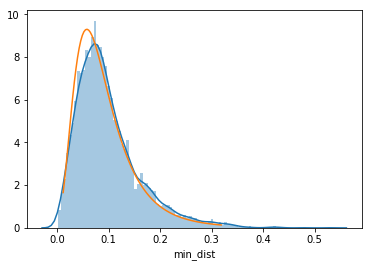

In [241]:
sns.distplot(df_peak['min_dist'], bins = 100, norm_hist = True)
plt.plot(x, scipy.stats.betaprime.pdf(x,*beta_prime_parameters))

In [249]:
new_parameters = scipy.stats.betaprime.fit(df_peak['min_dist'])
print(new_parameters)

(4.449289034920325, 12.777961268954916, -0.009031368689570645, 0.2840353229095878)


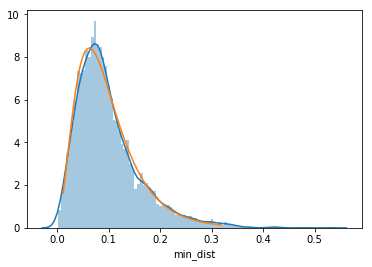

In [250]:
sns.distplot(df_peak['min_dist'], bins = 100, norm_hist = True)
plt.plot(x, scipy.stats.betaprime.pdf(x,*new_parameters))

In [106]:
shifts[:,].shape

(100, 4, 2)

In [252]:
np.array(peak_detection_output)[:,1]

array([0., 2., 1., ..., 1., 0., 0.])

In [253]:
np.shape(np.where(np.array(peak_detection_output)[:,1]!=0))

(1, 1716)

In [254]:
np.array(peak_detection_output).shape

(10000, 8)

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 22 columns):
nb_blended_gal               100 non-null int64
SNR                          100 non-null float64
SNR_peak                     100 non-null float64
redshift                     100 non-null float64
moment_sigma                 100 non-null float64
e1                           100 non-null float64
e2                           100 non-null float64
mag                          100 non-null float64
mag_ir                       100 non-null float64
closest_x                    75 non-null float64
closest_y                    75 non-null float64
closest_redshift             75 non-null float64
closest_moment_sigma         75 non-null float64
closest_e1                   75 non-null float64
closest_e2                   75 non-null float64
closest_mag                  75 non-null float64
closest_mag_ir               75 non-null float64
blendedness_total_lsst       75 non-null float64
blended